In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn import decomposition, preprocessing, linear_model, discriminant_analysis, neighbors
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, recall_score, roc_curve, auc, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.preprocessing import scale
import itertools
# from statMlFunctions import *
#import seaborn as sns
#sns.set(context='paper', style='whitegrid', color_codes=True, font_scale=1.8)
#sns.set_palette(sns.color_palette("Set1", n_colors=12, desat=.5))
import seaborn as sns
sns.set(context='paper', style='whitegrid', color_codes=True, font_scale=1.8)
colorcycle = [(0.498, 0.788, 0.498),
              (0.745, 0.682, 0.831),
              (0.992, 0.753, 0.525),
              (0.220, 0.424, 0.690),
              (0.749, 0.357, 0.090),
              (1.000, 1.000, 0.600),
              (0.941, 0.008, 0.498),
              (0.400, 0.400, 0.400)]
sns.set_palette(colorcycle) 

%matplotlib inline
# sns.set(style="white")
# mpl.rcParams['figure.figsize'] = [10, 6]

In [2]:
def plotROC(target, prob, ax=None):
    """Create a ROC plot.

    Parameters
    ----------
    target : array of ints or similar categorical
        Correct answer.
    prob : array of floats
        Probabiliti to predict target.
    ax : None, Matplotlib axis
        Matplotlib axis

    Returns
    -------
    tuple
        (fig, ax, auc)
    """
    assert len(target) == len(prob), "target and prob must be the same size"
    fpr, tpr, threshold = roc_curve(target, prob)
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = ax.figure
    ax.plot(fpr, tpr, '.-', lw=0.5, markersize=4)
    ax.set_ylabel('TPR')
    ax.set_xlabel('FPR')
    aucscore = auc(fpr, tpr)
    print("AUC:", aucscore)
    return (fig, ax, aucscore)

### Load data

In [3]:
df0 = pd.read_table('RGender.dat', sep=' ').T
df0.head() 

,gender,bfi_worry.answer,bfi_stable.answer,bfi_few_art.answer,bfi_caring.answer,bfi_helpfull.answer,bfi_distract.answer,bfi_inventive.answer,bfi_tense.answer,bfi_talk.answer,...,bfi_work.answer,bfi_play.answer,bfi_lazy.answer,bfi_shy.answer,bfi_depressed.answer,bfi_art.answer,bfi_careless.answer,bfi_nervous.answer,bfi_forgive.answer,bfi_calm.answer
u1,0,2,2,2,3,3,3,1,0,4,...,1,3,1,1,1,1,3,0,3,3
u2,0,3,2,3,3,3,2,4,3,3,...,2,3,1,1,1,2,2,0,2,3
u3,0,2,3,3,3,3,2,2,2,1,...,2,2,3,3,1,1,3,1,3,3
u4,0,3,3,1,3,3,2,3,2,2,...,3,4,2,2,2,3,1,1,3,3
u5,1,2,4,2,4,4,0,2,1,3,...,3,4,0,3,0,1,0,2,2,2


In [4]:
df1 = df0.drop('gender', axis=1)
df1.rename(columns=lambda s: s.replace('bfi_', '').replace('.answer', ''), inplace=True)
df1.head() 

,worry,stable,few_art,caring,helpfull,distract,inventive,tense,talk,reliable,...,work,play,lazy,shy,depressed,art,careless,nervous,forgive,calm
u1,2,2,2,3,3,3,1,0,4,3,...,1,3,1,1,1,1,3,0,3,3
u2,3,2,3,3,3,2,4,3,3,3,...,2,3,1,1,1,2,2,0,2,3
u3,2,3,3,3,3,2,2,2,1,2,...,2,2,3,3,1,1,3,1,3,3
u4,3,3,1,3,3,2,3,2,2,3,...,3,4,2,2,2,3,1,1,3,3
u5,2,4,2,4,4,0,2,1,3,3,...,3,4,0,3,0,1,0,2,2,2


In [5]:
gender = df0.gender

In [6]:
gender.value_counts() 

0    720
1    220
Name: gender, dtype: int64

In [7]:
df1.shape

(940, 43)

### Plot cross correlation

Remove this, since the cross correlation between the variables aren't af any real interest?

{0.60423046110269141: (-0.60423046110269141, 18, 8),
 0.61647711085610934: (-0.61647711085610934, 18, 13),
 0.62817868320639625: (0.62817868320639625, 37, 25),
 0.63863734226259894: (0.63863734226259894, 13, 8)}

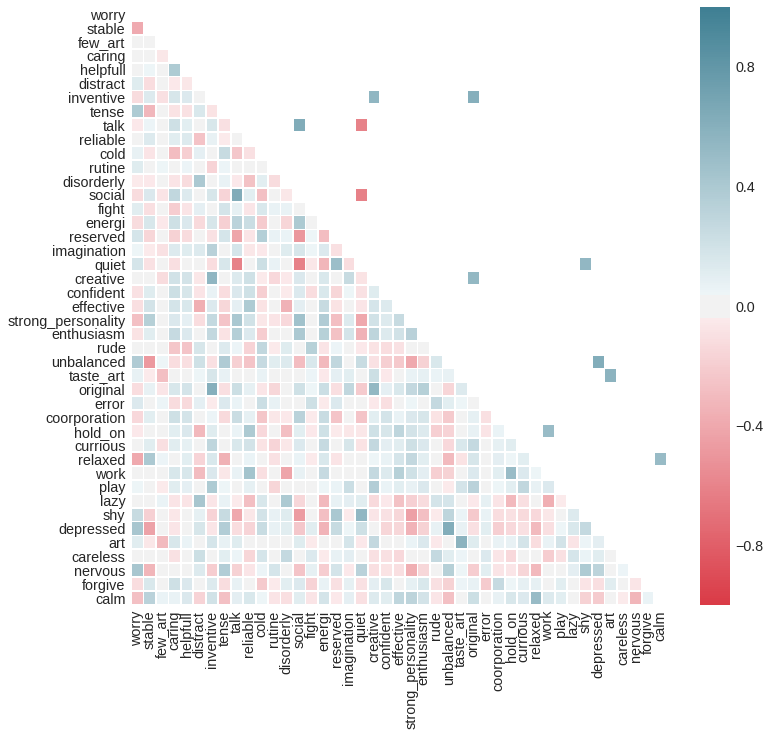

In [8]:
mpl.rcParams['text.usetex'] = False
mpl.rcParams['text.latex.unicode'] = False

def plotCrossCorr(df, threshold=None):
    
    df = df.copy() 
    corr = df.corr()
    corrval = corr.values
    mask = np.eye(*corr.shape)
    if threshold is None:
        mask[np.triu_indices_from(mask)] = 1
    else:
        mask[np.triu_indices_from(mask, k=1)] = np.abs(corrval[np.triu_indices_from(mask, k=1)]) < threshold
    fig, ax = plt.subplots(figsize=(12, 11))
    cmap = sns.diverging_palette(10, 220, as_cmap=True)
    sns.heatmap(corr, vmin=-1, vmax=1, cmap=cmap, mask=mask, linewidths=0.8, ax=ax)
    return fig, ax, corrval

fig, ax, corrval = plotCrossCorr(df1, threshold=0.5);
fig.savefig('data_cross_correlation.pdf')


class LargestElements:
    """Container for n absolute largest elements"""
    def __init__(self, n):
        self.n = n
        self.absdct = dict()

    def add(self, val, i, j):
        absval = np.abs(val)
        keys = self.absdct.keys()
        if len(self.absdct) < self.n or absval > min(keys):
            self.absdct[absval] = (val, i, j)
        if len(self.absdct) > self.n:
            del self.absdct[min(keys)]

    def get(self):
        return self.absdct


def max_abs_n_idx_triu(arr, n):
    le = LargestElements(n)
    for i in range(arr.shape[0]):
        for j in range(i):
            if i == j:
                continue
            le.add(arr[i, j], i, j)
    return le.get()


max_abs_n_idx_triu(corrval, 4)

## Logistic regression on the raw data

In [9]:
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.unicode'] = True

In [10]:
lr = linear_model.LogisticRegression(penalty='l2')
lr.fit(df1.values, gender.values)
prob1 = lr.predict_proba(df1.values)[:, 1]

In [11]:
accuracy_score(gender.values, prob1>0.5)

0.83510638297872342

In [12]:
confusion_matrix(gender.values, prob1>0.5)

array([[685,  35],
       [120, 100]])

In [13]:
len([(t, p) for (t, p) in zip(gender.values.astype(int), (prob1>0.5).astype(int)) if (t & p)])

100

In [14]:
len([(t, p) for (t, p) in zip(gender.values.astype(int), (prob1>0.5).astype(int)) if ((t==0) & (p==0))])

685

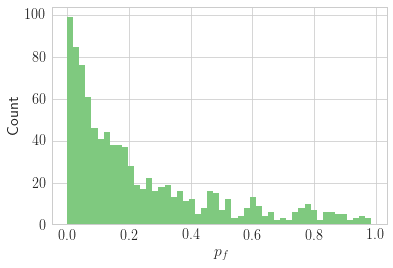

In [15]:
fig, ax = plt.subplots()
ax.hist(prob1, bins=50)
ax.set_xlabel('$p_f$')
ax.set_ylabel('Count')
fig.savefig('sex_prediction_raw_data_prob1_vs_count.pdf')

AUC: 0.84740530303


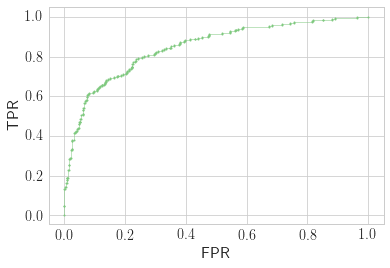

In [16]:
fig, ax, accscore = plotROC(gender.values, prob1)
fig.savefig('sex_prediction_raw_data.pdf')

### Logistic regression on the _expanded_ raw data

Expand the data with products accross _all_ variables

In [17]:
idx = np.arange(df1.values.shape[1]).astype(int)
idxCombinations = list(itertools.product(idx, idx))
featureMatrix = np.NaN * np.zeros((df1.values.shape[0], df1.values.shape[1]+len(idxCombinations)))

In [18]:
featureMatrix[:, :df1.values.shape[1]] = df1.values.copy() 

In [19]:
for i, (v0, v1) in enumerate(idxCombinations, df1.values.shape[1]):
    featureMatrix[:, i] = featureMatrix[:, v0] * featureMatrix[:, v1]

In [20]:
lre = linear_model.LogisticRegression()
lre.fit(featureMatrix, gender.values)
prob1 = lre.predict_proba(featureMatrix)[:, 1]

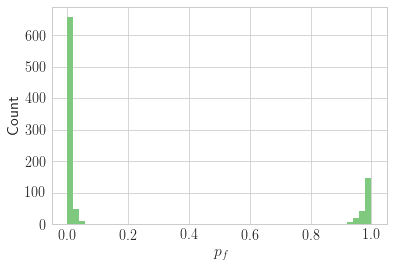

In [21]:
fig, ax = plt.subplots()
ax.hist(prob1, bins=50)
ax.set_xlabel('$p_f$')
ax.set_ylabel('Count')
fig.savefig('sex_prediction_expanded_data_prob1_vs_count.pdf')

In [22]:
accuracy_score(gender.values, prob1>0.5) 

1.0

AUC: 1.0


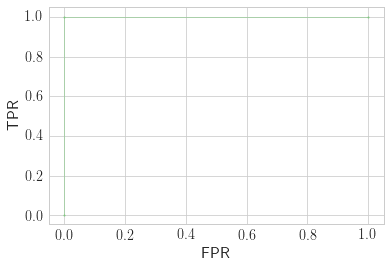

In [23]:
fig, ax, aucscore = plotROC(gender.values, prob1)
fig.savefig('sex_prediction_expanded_data.pdf')

### Perform PCA 

In [24]:
nd1 = scale(df1.values)
pca = decomposition.PCA(svd_solver='full') 
pca.fit(nd1)

/lscr_paper/allan/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, _DataConversionWarning)


PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='full', tol=0.0, whiten=False)

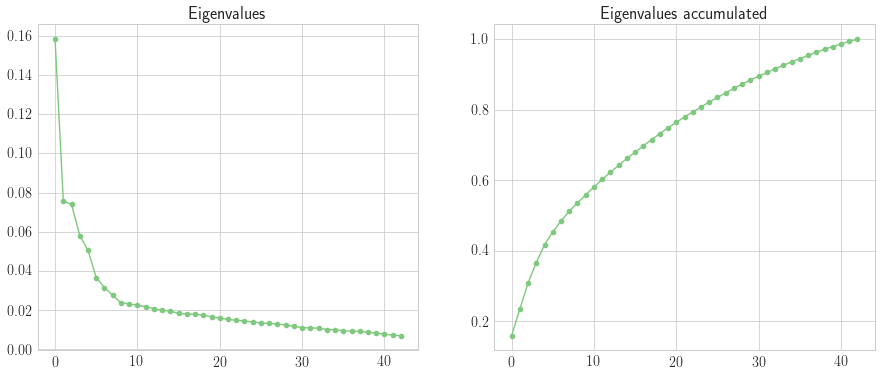

In [25]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(15, 6)) 
ax0.plot(pca.explained_variance_ratio_, 'o-')
ax1.plot(np.cumsum(pca.explained_variance_ratio_), 'o-')
ax0.set_title('Eigenvalues')
ax1.set_title('Eigenvalues accumulated')

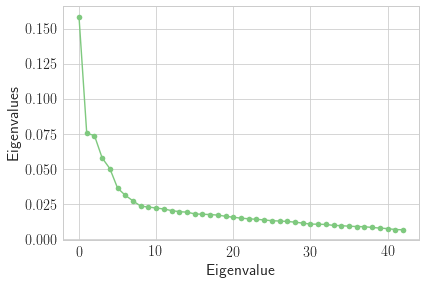

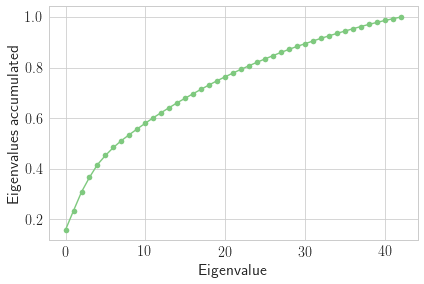

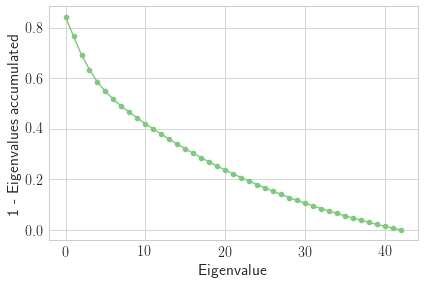

In [26]:
# For saving output

fig, ax = plt.subplots() 
ax.plot(pca.explained_variance_ratio_, 'o-')
ax.set_xlabel('Eigenvalue #')
ax.set_ylabel('Eigenvalues')
plt.tight_layout() 
fig.subplots_adjust(left=0.15, bottom=0.15)
fig.savefig('pca_eigenvalues.pdf')

fig, ax = plt.subplots()
ax.plot(np.cumsum(pca.explained_variance_ratio_), 'o-')
ax.set_xlabel('Eigenvalue #')
ax.set_ylabel('Eigenvalues accumulated')
plt.tight_layout() 
fig.subplots_adjust(bottom=0.15)
fig.savefig('pca_eigenvalues_accumulated.pdf')

fig, ax = plt.subplots()
ax.plot(1 - np.cumsum(pca.explained_variance_ratio_), 'o-')
ax.set_xlabel('Eigenvalue #')
ax.set_ylabel('1 - Eigenvalues accumulated')
plt.tight_layout() 
fig.subplots_adjust(bottom=0.15)
fig.savefig('pca_eigenvalues_scree.pdf')

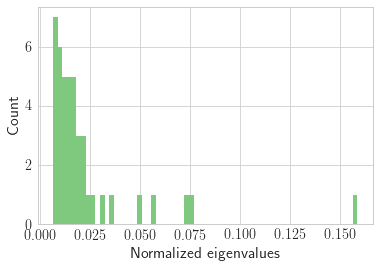

In [27]:
fig, ax = plt.subplots()
ax.hist(pca.explained_variance_ratio_, bins=65);
ax.set_xlabel('Normalized eigenvalues')
ax.set_ylabel('Count')
fig.savefig('pca_eigenvalues_histogram.pdf')

In [28]:
td1 = pca.transform(nd1)  # The rotated vector space

In [29]:
td1[:, 0].std() 

2.6110289430470286

In [30]:
td1.shape

(940, 43)

In [31]:
td1[0, :]

array([-2.19641937, -1.03082044,  4.17571265, -2.81660883,  0.97605846,
       -0.69470062, -0.54247447,  1.32476581, -1.32540257,  1.14641027,
        0.24803062,  2.87278593, -0.2158852 ,  0.33599238,  1.32342735,
       -0.21672217, -0.73980911, -2.34796089,  2.18566218,  0.38994065,
       -0.20405752,  1.07815522, -1.04322253,  1.58684831,  1.25958581,
       -0.31772547, -0.13609862, -0.2708887 , -0.42193686,  0.78868448,
       -1.03114661,  1.30724575,  0.13794711,  0.33258815, -1.08081977,
        0.73522949,  0.92194726, -0.06186103, -0.44397312, -0.06544148,
        0.4967489 ,  0.62681943,  0.15398389])

In [32]:
td1.shape

(940, 43)

### Logistic Regression

Try the prediction with a different number of leading vectors, and plot the accuracy for the prediction

Accuracy using 1 leading component(s) is 76.60 % 
Accuracy using 2 leading component(s) is 76.60 % 
Accuracy using 3 leading component(s) is 76.81 % 
Accuracy using 4 leading component(s) is 81.06 % 
Accuracy using 5 leading component(s) is 82.23 % 
Accuracy using 6 leading component(s) is 82.45 % 
Accuracy using 7 leading component(s) is 81.91 % 
Accuracy using 8 leading component(s) is 81.91 % 
Accuracy using 9 leading component(s) is 81.81 % 


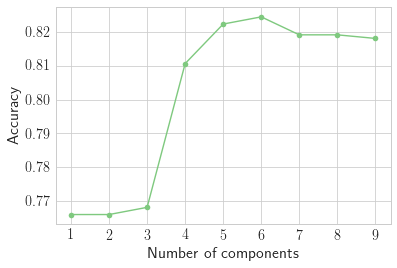

In [33]:
res = np.zeros((9, 2))
fig, ax = plt.subplots()
for k in range(1, 10):
    lr = linear_model.LogisticRegressionCV()
    lr.fit(td1[:, :k], gender.values)
    td1p = lr.predict(td1[:, :k]) 
    acc = accuracy_score(gender.values, td1p)
    print("Accuracy using {} leading component(s) is {:.2f} % ".format(k, acc*100))
    res[k-1, 0] = k
    res[k-1, 1] = acc
ax.plot(res[:, 0], res[:, 1], '-o')
ax.set_xlabel("Number of components")
ax.set_ylabel("Accuracy");
ax.set_xticks(np.arange(1, 10))
fig.savefig('pca_linear_regression_accuracy_vs_components.pdf')

Accuracy using 1 leading component(s) is 76.60 % 
Accuracy using 2 leading component(s) is 76.60 % 
Accuracy using 3 leading component(s) is 76.91 % 
Accuracy using 4 leading component(s) is 81.17 % 
Accuracy using 5 leading component(s) is 82.23 % 
Accuracy using 6 leading component(s) is 82.45 % 
Accuracy using 7 leading component(s) is 81.81 % 
Accuracy using 8 leading component(s) is 81.91 % 
Accuracy using 9 leading component(s) is 81.60 % 
Accuracy using 1 leading component(s) is 76.60 % 
Accuracy using 2 leading component(s) is 76.60 % 
Accuracy using 3 leading component(s) is 76.60 % 
Accuracy using 4 leading component(s) is 81.60 % 
Accuracy using 5 leading component(s) is 82.13 % 
Accuracy using 6 leading component(s) is 82.98 % 
Accuracy using 7 leading component(s) is 82.98 % 
Accuracy using 8 leading component(s) is 82.34 % 
Accuracy using 9 leading component(s) is 82.13 % 


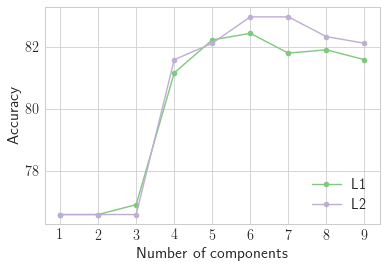

In [34]:
res = np.zeros((9, 2))
fig, ax = plt.subplots()
for reg in 'l1 l2'.split():
    for k in range(1, 10):
        lr = linear_model.LogisticRegressionCV(penalty=reg, solver='liblinear')
        lr.fit(td1[:, :k], gender.values)
        td1p = lr.predict(td1[:, :k]) 
        acc = (td1p == gender.values).sum() / gender.size * 100
        print("Accuracy using {} leading component(s) is {:.2f} % ".format(k, acc))
        res[k-1, 0] = k
        res[k-1, 1] = acc
    ax.plot(res[:, 0], res[:, 1], '-o', label=reg.upper())
ax.set_xlabel("Number of components")
ax.set_ylabel("Accuracy");
ax.set_yticks([78, 80, 82])
ax.set_xticks(np.arange(1, 10))
ax.legend(loc="lower right")
fig.savefig('pca_linear_regression_L1_L2_accuracy_vs_components.pdf')

Fit a Logistic Regression prediction with $k = 5$ components, and plot each vector component against the gender and the prediction probability

#### Elastic net regression: Combining L1 and L2 regularization

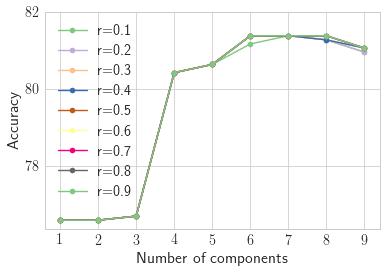

In [35]:
res = np.zeros((9, 2))
fig, ax = plt.subplots()
for r in np.linspace(0.1, 0.9, 9):
    for k in range(1, 10):
        lr = linear_model.ElasticNetCV(l1_ratio=r)
        lr.fit(td1[:, :k], gender.values)
        td1p = lr.predict(td1[:, :k]) 
        acc = accuracy_score(gender.values, td1p > 0.5) * 100
        # print("Accuracy using {} leading component(s) is {:.2f} % ".format(k, acc))
        res[k-1, 0] = k
        res[k-1, 1] = acc
    ax.plot(res[:, 0], res[:, 1], '-o', label='r=%.1f' % r)
ax.set_xlabel("Number of components")
ax.set_ylabel("Accuracy");
ax.set_yticks([78, 80, 82])
ax.set_xticks(np.arange(1, 10));
ax.legend() 
fig.savefig('pca_linear_regression_elastic_net_accuracy_vs_components.pdf')

In [36]:
k = 5
X = td1[:, :k]  # fit using the first k components
lr = linear_model.LogisticRegression()
lr.fit(X, gender.values)
prob1 = lr.predict_proba(X)[:, 1]

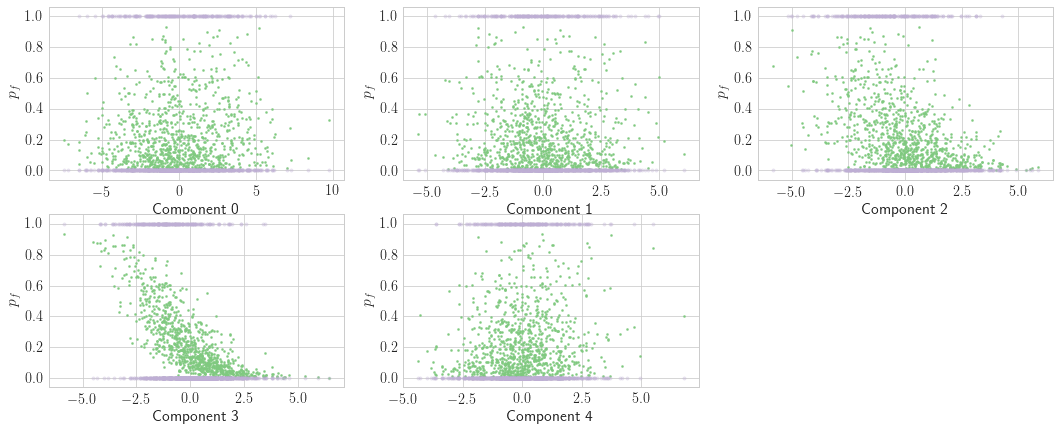

In [37]:
fig, axi = plt.subplots(2, 3, figsize=(18, 7))
axi = axi.flatten()
for i in range(k):
    axi[i].scatter(X[:, i], prob1, s=5)
    axi[i].scatter(X[:, i], gender.values, s=12, alpha=0.35)
    axi[i].set_xlabel("Component %d" % i)
    axi[i].set_ylabel(r"$p_f$")
axi[-1].remove() 

Make the plots again, but save in indivudial files

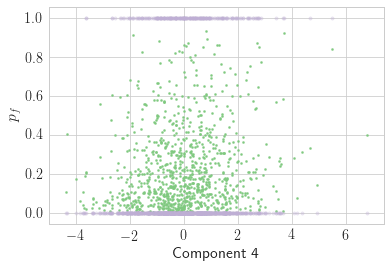

In [38]:
fig, ax = plt.subplots()
for i in range(k):
    ax.cla() 
    ax.scatter(X[:, i], prob1, s=5)
    ax.scatter(X[:, i], gender.values, s=12, alpha=0.35)
    ax.set_xlabel("Component %d" % i)
    ax.set_ylabel(r"$p_f$")
    fig.savefig(f'pca_component_{i}_vs_prob1.pdf')


Component 3 looks interesting. Check the accuracy with just that component.

More thorough examination of the components

[[ 0.52421086  0.47496843  0.3411048   0.23659722  0.54164141]
 [ 0.47578914  0.52503157  0.6588952   0.76340278  0.45835859]
 [ 0.47578914  0.52503157  0.6588952   0.76340278  0.45835859]
 [ 0.47578914  0.52503157  0.6588952   0.76340278  0.45835859]
 [ 0.52421086  0.47496843  0.3411048   0.23659722  0.54164141]]


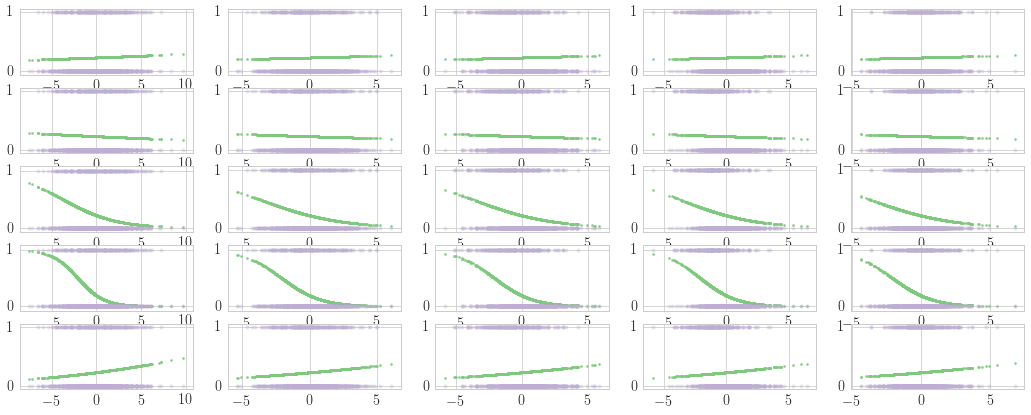

In [39]:
fig, axi = plt.subplots(5, 5, figsize=(18, 7))
axi = axi.flatten()
ac = 0
aucmat = np.zeros((k, k))
lr2 = linear_model.LogisticRegression(solver='newton-cg')
for i in range(k):
    X = td1[:, i][:, np.newaxis]
    lr2.fit(X, gender.values)
    for j in range(k):
        XX = td1[:, j]
        prob1 = lr2.predict_proba(XX[:, np.newaxis])[:, 1]
        axi[ac].scatter(XX, prob1, s=5)
        axi[ac].scatter(XX, gender.values, s=12, alpha=0.35)
        # axi[ac].set_title(f"fit: X[:,{i}], predict: X[:,{j}]")
        ac += 1
        aucmat[i, j] = roc_auc_score(gender.values, prob1)
fig.set
fig.savefig('gridplot.png', dpi=400)
print(aucmat)

### ROC curves

AUC: 0.807537878788


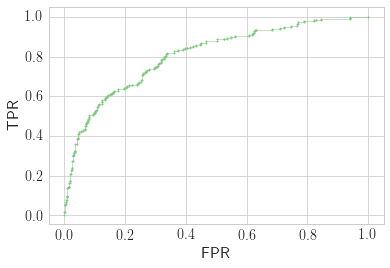

In [40]:
fig, ax, aucscore = plotROC(gender.values, lr.predict_proba(td1[:, :k])[:, 1])
fig.savefig('logistic_regression_pca_roc_curve.pdf') 

### Randomly sampled components

Randomly sample $k = 5$ components 1000 times, collect the AUC-scores and plot a histogram over them.

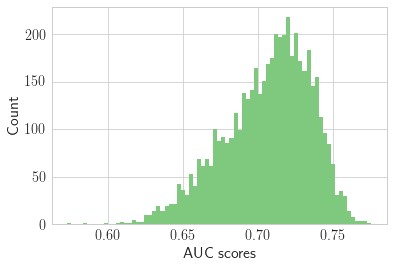

In [41]:
k = 5
N = 5000
idx_set = set()
while len(idx_set) < N:
    idx_set.add(tuple(list(set(np.random.choice(np.arange(df1.shape[1], dtype=int), k*3)))[:k]))

lr = linear_model.LogisticRegression()
auc_scores = np.zeros(N)
for i, idx in enumerate(idx_set):
    # idx = list(set(np.random.choice(np.arange(df1.shape[1], dtype=int), k*3)))[:k] # k unique indexes
    dfX = df1.iloc[:, idx]
    X = dfX.values
    lr.fit(X, gender.values)
    auc_scores[i] = roc_auc_score(gender.values, lr.predict_proba(X)[:, 1])
fig, ax = plt.subplots()
ax.hist(auc_scores, bins=75);
ax.set_xlabel('AUC scores')
ax.set_ylabel('Count')
fig.savefig(f'logistic_regression_auc_score_{k}_random_feature_sampling.pdf')

## Split data for cross validation


In [42]:
X_train, X_test, y_train, y_test = train_test_split(td1, gender.values, test_size=0.3, stratify=gender.values)

In [43]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(658, 43) (282, 43) (658,) (282,)


### Use Linear Discriminant analysis

In [44]:
lda = discriminant_analysis.LinearDiscriminantAnalysis(store_covariance=True)

In [45]:
lda.fit(X_train, y_train)

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=True, tol=0.0001)

In [46]:
accuracy_score(y_test, lda.predict(X_test))

0.79432624113475181

LDA didn't fare that good, but it's comparable to the SVM accuracy.

#### Also try QDA

It fares even worse, but a grid search is in order!

In [47]:
qda = discriminant_analysis.QuadraticDiscriminantAnalysis(store_covariances=True) 

In [48]:
qda.fit(X_train, y_train)

QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
               store_covariances=True, tol=0.0001)

In [49]:
accuracy_score(y_test, qda.predict(X_test))

0.77304964539007093

### Use kNN

A real grid search with cross validation should be performed.

And ROC-curves shoud be created.

In [50]:
knn = neighbors.KNeighborsClassifier(p=4, n_neighbors=12)

In [51]:
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=12, p=4,
           weights='uniform')

In [52]:
accuracy_score(y_test, knn.predict(X_test))

0.77304964539007093

### Use some support vector machines

Train a support vector machines

In [53]:
clf = SVC(kernel='linear', C=1)
scores = cross_val_score(clf, X_train, y_train, cv=5)
scores

array([ 0.8030303 ,  0.79545455,  0.76515152,  0.85606061,  0.8       ])

In [54]:
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.80 (+/- 0.06)


Not a bad accuracy, but let's do a real grid search for parameter optimization.

### Do a real cross validation grid search?

Do this: `file:///Users/allan/Library/Application%20Support/Dash/User%20Contributed/Scikitlearn/Scikit-learn.docset/Contents/Resources/Documents/modules/cross_validation.html#the-cross-validate-function-and-multiple-metric-evaluation`

Supress warnings about invalied measure due to category with 0 results

In [55]:
import warnings
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

In [56]:
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, train_test_split


In [57]:
tuned_parameters = [{'C': [0.01, 0.1, 1, 10, 100, 1000], 'penalty': ['l1', 'l2']}]
scores = ['precision_macro', 'recall_macro', 'accuracy']
print(tuned_parameters, scores)

[{'C': [0.01, 0.1, 1, 10, 100, 1000], 'penalty': ['l1', 'l2']}] ['precision_macro', 'recall_macro', 'accuracy']


In [58]:
for score in scores:
    clf = GridSearchCV(linear_model.LogisticRegression(), param_grid=tuned_parameters,
                       scoring=score, n_jobs=32) 
    clf.fit(X_train, y_train)
    print(f"""----------------------------------------------------------------
    Best parameters set found on development set using {score} for evaluation:

    {clf.best_params_}

    Grid scores on development set:
    """)
    
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
    
    print("""

    Detailed classification report:

    The model is trained on the full development set.
    The scores are computed on the full evaluation set.
    """)

    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()


----------------------------------------------------------------
    Best parameters set found on development set using precision_macro for evaluation:

    {'C': 0.1, 'penalty': 'l1'}

    Grid scores on development set:
    
0.601 (+/-0.333) for {'C': 0.01, 'penalty': 'l1'}
0.742 (+/-0.079) for {'C': 0.01, 'penalty': 'l2'}
0.787 (+/-0.064) for {'C': 0.1, 'penalty': 'l1'}
0.733 (+/-0.068) for {'C': 0.1, 'penalty': 'l2'}
0.757 (+/-0.048) for {'C': 1, 'penalty': 'l1'}
0.741 (+/-0.047) for {'C': 1, 'penalty': 'l2'}
0.738 (+/-0.046) for {'C': 10, 'penalty': 'l1'}
0.744 (+/-0.049) for {'C': 10, 'penalty': 'l2'}
0.744 (+/-0.049) for {'C': 100, 'penalty': 'l1'}
0.744 (+/-0.049) for {'C': 100, 'penalty': 'l2'}
0.744 (+/-0.049) for {'C': 1000, 'penalty': 'l1'}
0.744 (+/-0.049) for {'C': 1000, 'penalty': 'l2'}


    Detailed classification report:

    The model is trained on the full development set.
    The scores are computed on the full evaluation set.
    
             precision    recall 

In [59]:
lr = linear_model.LogisticRegression(**clf.best_params_)
lr.fit(X_train, y_train) 

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

AUC: 0.828554292929


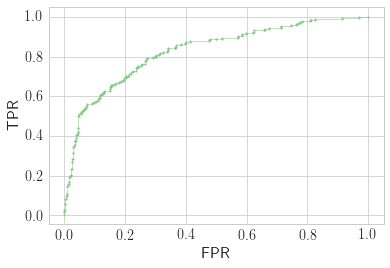

In [60]:
fig, ax, aucscore = plotROC(gender.values, lr.predict_proba(td1)[:, 1]) 
fig.savefig('logistic_regression_all_data_predict_train_data_training_roc_curve.pdf')

AUC: 0.847724695939


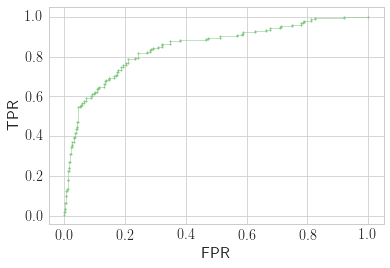

In [61]:
fig, ax, aucscore = plotROC(y_train, lr.predict_proba(X_train)[:, 1])
fig.savefig('logistic_regression_training_data_roc_curve.pdf') 

AUC: 0.780864197531


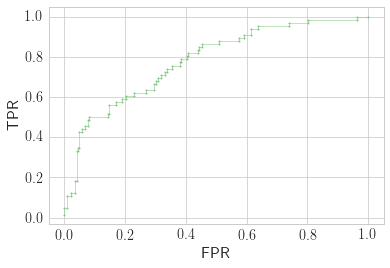

In [62]:
fig, ax, aucscore = plotROC(y_test, lr.predict_proba(X_test)[:, 1])
fig.savefig('logistic_regression_test_data_roc_curve.pdf')

In [63]:
tuned_parameters = [{'kernel': ['rbf', 'linear', 'poly'],
                     'gamma': [1e-2, 1e-3, 1e-4, 1e-5],
                     'C': [0.1, 1, 10, 100, 1000]}]
scores = ['precision', 'recall', 'accuracy']
print(tuned_parameters, scores)

[{'kernel': ['rbf', 'linear', 'poly'], 'gamma': [0.01, 0.001, 0.0001, 1e-05], 'C': [0.1, 1, 10, 100, 1000]}] ['precision', 'recall', 'accuracy']


In [64]:
for score in scores:
    clf = GridSearchCV(SVC(), param_grid=tuned_parameters,
                       scoring="%s_macro" % score, n_jobs=32) 
    clf.fit(X_train, y_train)
    print(f"""----------------------------------------------------------------
    Best parameters set found on development set using {score} for evaluation:

    {clf.best_params_}

    Grid scores on development set:
    """)
    
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
    
    print("""

    Detailed classification report:

    The model is trained on the full development set.
    The scores are computed on the full evaluation set.
    """)

    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()


----------------------------------------------------------------
    Best parameters set found on development set using precision for evaluation:

    {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}

    Grid scores on development set:
    
0.383 (+/-0.002) for {'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}
0.745 (+/-0.073) for {'C': 0.1, 'gamma': 0.01, 'kernel': 'linear'}
0.383 (+/-0.002) for {'C': 0.1, 'gamma': 0.01, 'kernel': 'poly'}
0.383 (+/-0.002) for {'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}
0.745 (+/-0.073) for {'C': 0.1, 'gamma': 0.001, 'kernel': 'linear'}
0.383 (+/-0.002) for {'C': 0.1, 'gamma': 0.001, 'kernel': 'poly'}
0.383 (+/-0.002) for {'C': 0.1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.745 (+/-0.073) for {'C': 0.1, 'gamma': 0.0001, 'kernel': 'linear'}
0.383 (+/-0.002) for {'C': 0.1, 'gamma': 0.0001, 'kernel': 'poly'}
0.383 (+/-0.002) for {'C': 0.1, 'gamma': 1e-05, 'kernel': 'rbf'}
0.745 (+/-0.073) for {'C': 0.1, 'gamma': 1e-05, 'kernel': 'linear'}
0.383 (+/-0.002) for {'C': 0.1, 

ValueError: 'accuracy_macro' is not a valid scoring value. Valid options are ['accuracy', 'adjusted_rand_score', 'average_precision', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'neg_log_loss', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_median_absolute_error', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'r2', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'roc_auc']

In [ ]:
svc = SVC(probability=True, **clf.best_params_) 
svc.fit(X_train, y_train) 

In [ ]:
fig, ax, aucscore = plotROC(gender.values, svc.predict_proba(td1)[:, 1])
fig.savefig('svm_all_data_predict_train_data_training_roc_curve.pdf')

In [ ]:
fig, ax, aucscore = plotROC(y_train, svc.predict_proba(X_train)[:, 1])
fig.savefig('svm_training_data_roc_curve.pdf')

In [ ]:
fig, ax, aucscore = plotROC(y_test, svc.predict_proba(X_test)[:, 1])
fig.savefig('svm_test_data_roc_curve.pdf')

In [ ]:
tuned_parameters = [dict(n_estimators=np.ceil(2**np.linspace(1, 8, 10)).astype(int),
                         max_depth=[3, 5, 8, 12, 16, 25])]

print(tuned_parameters)

In [ ]:
for score in scores:
    clf = GridSearchCV(RandomForestClassifier(), param_grid=tuned_parameters, scoring="%s_macro" % score, n_jobs=32) 
    clf.fit(X_train, y_train)
    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
    print()
    
    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()

In [ ]:
clf.best_estimator_

In [ ]:
fig, ax, aucscore = plotROC(gender.values, clf.best_estimator_.predict_proba(td1)[:, 1])
fig.savefig('random_forrest_all_data_roc_curve.pdf')

In [ ]:
fig, ax, aucscore = plotROC(y_train, clf.best_estimator_.predict_proba(X_train)[:, 1])
fig.savefig('random_forrest_training_data_roc_curve.pdf')

In [ ]:
fig, ax, aucscore = plotROC(y_test, clf.best_estimator_.predict_proba(X_test)[:, 1])
fig.savefig('random_forrest_test_data_roc_curve.pdf')